In [10]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/My Drive/Contests/Social_Science.csv'

df = pd.read_csv(data_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1270 entries, 0 to 1269
Data columns (total 20 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Profile.Astronaut Numbers.Overall             1270 non-null   int64  
 1   Profile.Astronaut Numbers.Nationwide          1270 non-null   int64  
 2   Profile.Name                                  1270 non-null   object 
 3   Profile.Gender                                1270 non-null   object 
 4   Profile.Birth Year                            1270 non-null   int64  
 5   Profile.Nationality                           1270 non-null   object 
 6   Profile.Military                              1270 non-null   bool   
 7   Profile.Selection.Group                       1270 non-null   object 
 8   Profile.Selection.Year                        1270 non-null   int64  
 9   Profile.Lifetime Statistics.Mission count     1270 non-null   i

In [12]:
earliest_male_selection_year = df[df['Profile.Gender'] == 'male']['Profile.Selection.Year'].min()
print(f"The earliest selection year for male astronauts is: {earliest_male_selection_year}")

The earliest selection year for male astronauts is: 1959


In [13]:
earliest_female_selection_year = df[df['Profile.Gender'] == 'female']['Profile.Selection.Year'].min()
print(f"The earliest selection year for female astronauts is: {earliest_female_selection_year}")

The earliest selection year for female astronauts is: 1962


## Polynomial Regression

### Subtask:
Train a polynomial regression model to predict the number of male and female astronauts based on the time feature.

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# df filtered by gender
df_filtered = df[['Profile.Gender', 'Profile.Selection.Year', 'Profile.Name', 'Mission.Durations.Mission duration', 'Mission.Durations.EVA duration', 'Profile.Lifetime Statistics.Mission duration', 'Profile.Lifetime Statistics.EVA duration']].copy()
earliest_selection_year = df_filtered['Profile.Selection.Year'].min()
df_filtered['Years Since First Astronaut'] = df_filtered['Profile.Selection.Year'] - earliest_selection_year
df_filtered = df_filtered.sort_values(by='Profile.Selection.Year')
df_filtered['Cumulative Astronauts'] = df_filtered.groupby('Profile.Gender').cumcount() + 1


#df seperated by gender AFTER adding new columns
men_df = df_filtered[df_filtered['Profile.Gender'] == 'male']
women_df = df_filtered[df_filtered['Profile.Gender'] == 'female']


# Prepare data for modeling
X_men = men_df['Years Since First Astronaut'].values.reshape(-1, 1)
y_men = men_df['Cumulative Astronauts']

X_women = women_df['Years Since First Astronaut'].values.reshape(-1, 1)
y_women = women_df['Cumulative Astronauts']

# Generate future years (assuming last_year is defined)
last_year = df_filtered['Years Since First Astronaut'].max()
future_years = np.arange(last_year + 1, last_year + 31).reshape(-1, 1)

In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Create polynomial features for both genders
degree = 2  # You can adjust the degree of the polynomial
poly_features = PolynomialFeatures(degree=degree)
X_men_poly = poly_features.fit_transform(X_men)
X_women_poly = poly_features.fit_transform(X_women)

# Train polynomial regression models
model_men_poly = LinearRegression()
model_men_poly.fit(X_men_poly, y_men)

model_women_poly = LinearRegression()
model_women_poly.fit(X_women_poly, y_women)

LinearRegression()

## Prediction with Polynomial Regression

### Subtask:
Use the trained polynomial models to predict the future growth of men and women in the space workforce.

In [16]:
# Generate polynomial features for future years
future_years_poly = poly_features.transform(future_years)

# Predict using polynomial models
predicted_cumulative_astronauts_men_poly = model_men_poly.predict(future_years_poly)
predicted_cumulative_astronauts_women_poly = model_women_poly.predict(future_years_poly)

## Evaluation of Polynomial Regression

### Subtask:
Evaluate the polynomial models' performance.

In [17]:
r_squared_men_poly = model_men_poly.score(X_men_poly, y_men)
r_squared_women_poly = model_women_poly.score(X_women_poly, y_women)

print(f"R-squared score for men (Polynomial): {r_squared_men_poly}")
print(f"R-squared score for women (Polynomial): {r_squared_women_poly}")

R-squared score for men (Polynomial): 0.968130992894331
R-squared score for women (Polynomial): 0.9218026200822281


## Visualization with Polynomial Regression

### Subtask:
Visualize the historical data and the polynomial models' predictions.

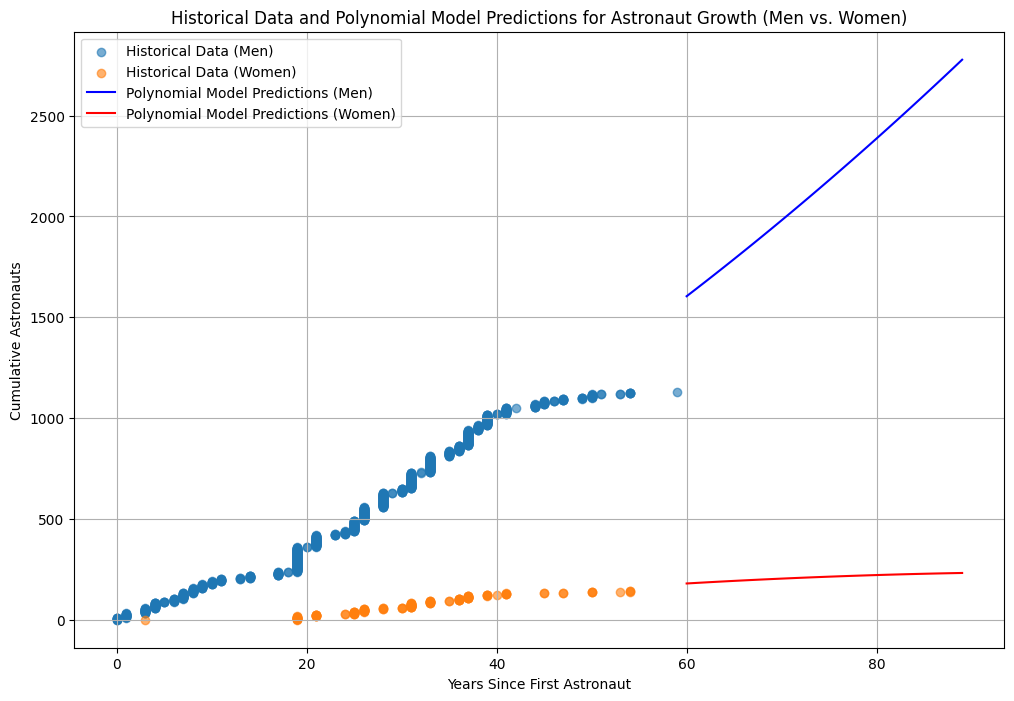

In [18]:
plt.figure(figsize=(12, 8))

# Plot historical data
plt.scatter(men_df['Years Since First Astronaut'], men_df['Cumulative Astronauts'], label='Historical Data (Men)', alpha=0.6)
plt.scatter(women_df['Years Since First Astronaut'], women_df['Cumulative Astronauts'], label='Historical Data (Women)', alpha=0.6)

# Plot polynomial model predictions
# To ensure a smooth curve, we need to sort the future years and corresponding predictions
sorted_future_years, sorted_predicted_men_poly = zip(*sorted(zip(future_years.flatten(), predicted_cumulative_astronauts_men_poly)))
sorted_future_years, sorted_predicted_women_poly = zip(*sorted(zip(future_years.flatten(), predicted_cumulative_astronauts_women_poly)))


plt.plot(sorted_future_years, sorted_predicted_men_poly, color='blue', linestyle='-', label='Polynomial Model Predictions (Men)')
plt.plot(sorted_future_years, sorted_predicted_women_poly, color='red', linestyle='-', label='Polynomial Model Predictions (Women)')

plt.xlabel('Years Since First Astronaut')
plt.ylabel('Cumulative Astronauts')
plt.title('Historical Data and Polynomial Model Predictions for Astronaut Growth (Men vs. Women)')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
coefficient_men = np.polyfit(sorted_future_years, sorted_predicted_men_poly, 2)
coefficient_women = np.polyfit(sorted_future_years, sorted_predicted_women_poly, 2)


polynomial_function = np.poly1d(coefficient_men)
print(f"Polynomial Function: \n{polynomial_function}")

polynomial_function = np.poly1d(coefficient_women)
print(f"Polynomial Function: \n{polynomial_function}")

Polynomial Function: 
        2
0.1464 x + 18.62 x - 39.55
Polynomial Function: 
          2
-0.03233 x + 6.612 x - 99.66


In [20]:
from statsmodels.stats.proportion import proportions_ztest

successes = np.array([4422106, 2089032])
observations = np.array([6511138, 6511138])

z_stat, p_val = proportions_ztest(successes, observations)

print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_val}")

alpha = 0.05
if p_val < alpha:
  print("Reject the null hypothesis")
else:
  print("Fail to reject the null hypothesis")

Z-statistic: 1293.0492349870676
P-value: 0.0
Reject the null hypothesis


In [25]:
times_bigger = successes[0] / successes[1]
print(f"There are {round(times_bigger,2)} times as many men astronauts as there are women astronauts.")

There are 2.12 times as many men astronauts as there are women astronauts.
